# Regressão - Concreto com Fibras (ML + Keras)
Notebook com dados injetados e regressão ML (RandomForest) + Regressão Linear via Keras

In [1]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, losses, callbacks
import warnings
warnings.filterwarnings('ignore')
plt.style.use('default')

In [2]:
# --- Carregar dados ---
df_temp = pd.read_excel("teste banco de dados.xlsx", header=None)
header_row = df_temp[df_temp.apply(lambda x: x.astype(str).str.contains("Tipo do concreto", case=False, na=False)).any(axis=1)].index[0]
df = pd.read_excel("teste banco de dados.xlsx", header=header_row)
df = df.dropna(axis=1, how='all')
print("Colunas detectadas:")
print(df.columns.tolist())

Colunas detectadas:
['Tipo do concreto', 'fck (resistência)            [MPa]', 'l (comprimento)            [mm]', 'd (diâmetro            [mm]', 'l/d      (fator de forma             ', 'Teor de fibra (%)', 'N (ganchos)', 'fR,1 (N/mm²)      (experimental)', 'fR,3 (N/mm²)      (experimental)', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15']


In [3]:
# --- Seleção de features e alvo ---
prefer_targets = [
    'fR,1 (N/mm²)      (experimental)',
    'fR,3 (N/mm²)      (experimental)'
]
existing_targets = [c for c in prefer_targets if c in df.columns]
if not existing_targets:
    raise ValueError('Nenhuma coluna de alvo fR,1 ou fR,3 encontrada.')
target_col = existing_targets[0]
print('Coluna alvo escolhida:', target_col)

feature_cols = [
    'fck (resistência)            [MPa]',
    'l (comprimento)            [mm]',
    'd (diâmetro            [mm]',
    'l/d      (fator de forma             ',
    'Teor de fibra (%)',
    'N (ganchos)'
]
# Converter para numérico
for c in feature_cols:
    df[c] = pd.to_numeric(df[c].astype(str).str.replace(',', '.').str.replace('[^0-9\.-]', '', regex=True), errors='coerce')

work = df[feature_cols + [target_col]].dropna(subset=[target_col])
X = work[feature_cols].copy()
y = work[target_col].copy()

# Preencher NaNs com mediana
X = X.fillna(X.median(numeric_only=True))

# Split e escala
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

Coluna alvo escolhida: fR,1 (N/mm²)      (experimental)


In [4]:
# --- RandomForest ---
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_s, y_train)
y_pred_rf = rf.predict(X_test_s)
print('RandomForest - MSE:', mean_squared_error(y_test, y_pred_rf),
      'MAE:', mean_absolute_error(y_test, y_pred_rf),
      'R2:', r2_score(y_test, y_pred_rf))

# --- Regressão Linear via Keras (uma camada densa linear) ---
model = models.Sequential([
    layers.Input(shape=(X_train_s.shape[1],)),
    layers.Dense(1, activation='linear')
])
model.compile(optimizer=optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

history = model.fit(X_train_s, y_train, validation_split=0.2, epochs=300, batch_size=16, verbose=0,
                    callbacks=[callbacks.EarlyStopping(patience=20, restore_best_weights=True)])

y_pred_keras = model.predict(X_test_s).flatten()
print('Keras Linear - MSE:', mean_squared_error(y_test, y_pred_keras),
      'MAE:', mean_absolute_error(y_test, y_pred_keras),
      'R2:', r2_score(y_test, y_pred_keras))

RandomForest - MSE: 1.367464151415705 MAE: 0.7427436304916346 R2: 0.8094992347500954
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Keras Linear - MSE: 1.7297870541180147 MAE: 0.9883715779890095 R2: 0.7590242075540268


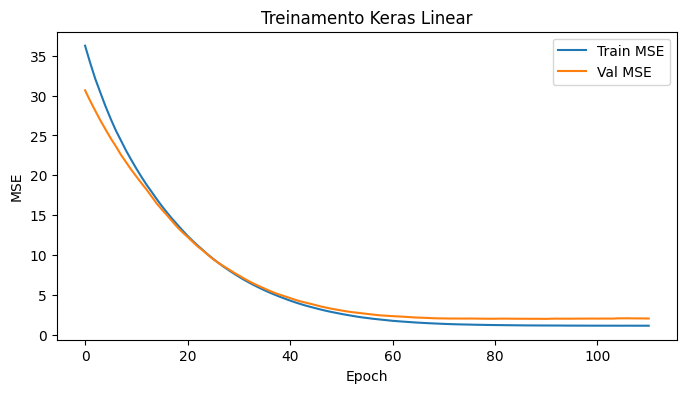

In [5]:
# --- Gráficos de treinamento Keras ---
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Treinamento Keras Linear')
plt.legend()
plt.show()

In [6]:
# --- Obter equação linear aproximada ---
weights = model.layers[0].get_weights()
coef_scaled = weights[0].flatten() / scaler.scale_
intercept = weights[1][0] - (weights[0].flatten() * (scaler.mean_ / scaler.scale_)).sum()

# Montar string da equação
terms = [f'{coef_scaled[i]:+.6g} * {feature_cols[i]}' for i in range(len(feature_cols))]
equation = f'y = {intercept:.6g} ' + ' '.join(terms)
print('Equação Linear aproximada (unidades originais):')
print(equation)

Equação Linear aproximada (unidades originais):
y = -2.90451 +0.0691842 * fck (resistência)            [MPa] +0.00858768 * l (comprimento)            [mm] -1.08297 * d (diâmetro            [mm] +0.0174089 * l/d      (fator de forma              +6.7958 * Teor de fibra (%) +0.324027 * N (ganchos)


In [7]:
# --- Função utilitária para prever usando a equação ---
def calcular_fr(**kwargs) -> float:
    vals = []
    for feat in feature_cols:
        if feat not in kwargs:
            raise KeyError(f"Falta o parâmetro: {feat}")
        vals.append(float(kwargs[feat]))
    vals = np.array(vals)
    return float(intercept + np.dot(coef_scaled, vals))

print('Use calcular_fr(...) passando as 6 variáveis com os nomes exatos para obter a previsão do alvo.')

Use calcular_fr(...) passando as 6 variáveis com os nomes exatos para obter a previsão do alvo.


MAE (equação Keras): 0.8956 | R2 (equação Keras): 0.7860


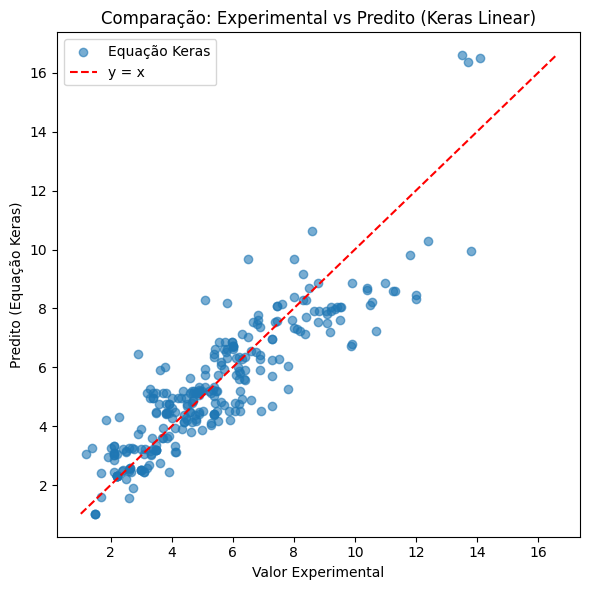

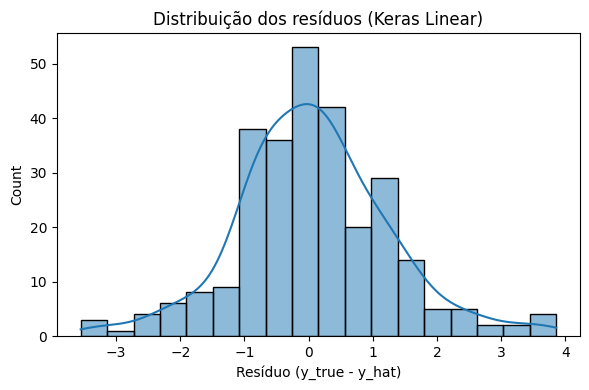

In [8]:
# --- Teste da equação linear aproximada ---
X_eq = X.copy()
y_hat_eq = intercept + np.dot(X_eq.values, coef_scaled)

# Métricas
mae_eq = mean_absolute_error(y, y_hat_eq)
r2_eq = r2_score(y, y_hat_eq)
print(f"MAE (equação Keras): {mae_eq:.4f} | R2 (equação Keras): {r2_eq:.4f}")

# Comparação gráfica
plt.figure(figsize=(6,6))
plt.scatter(y, y_hat_eq, alpha=0.6, label='Equação Keras')
mn = min(y.min(), y_hat_eq.min())
mx = max(y.max(), y_hat_eq.max())
plt.plot([mn,mx],[mn,mx],'r--', label='y = x')
plt.xlabel('Valor Experimental')
plt.ylabel('Predito (Equação Keras)')
plt.title('Comparação: Experimental vs Predito (Keras Linear)')
plt.legend()
plt.tight_layout()
plt.show()

# Resíduos
residuals_eq = y - y_hat_eq
plt.figure(figsize=(6,4))
sns.histplot(residuals_eq, kde=True)
plt.xlabel('Resíduo (y_true - y_hat)')
plt.title('Distribuição dos resíduos (Keras Linear)')
plt.tight_layout()
plt.show()

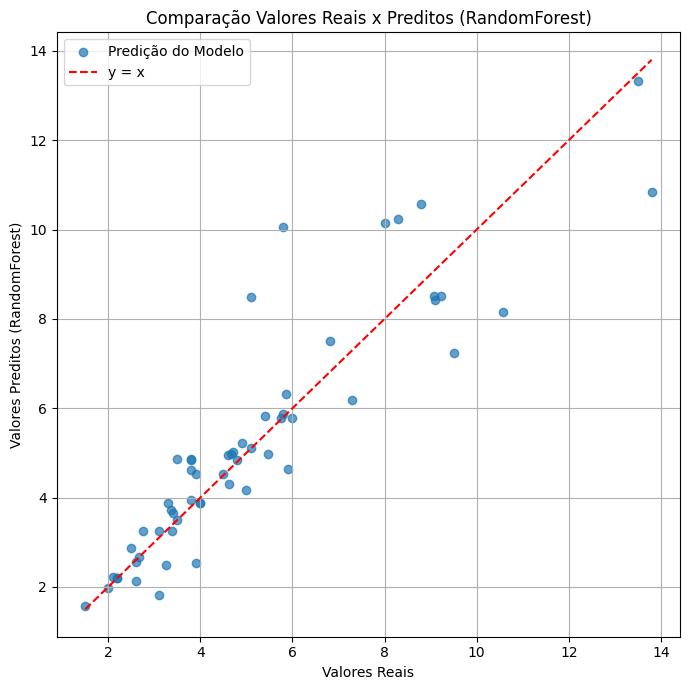

Gráfico salvo como 'pred_vs_real_RandomForest.png'


In [9]:
# Plot Predito vs Real (Machine Learning)
import matplotlib.pyplot as plt
import numpy as np

# Escolher qual modelo usar para plot: RandomForest ou DNN/Keras
if 'y_pred_rf' in globals():
    y_pred = y_pred_rf
    modelo_nome = 'RandomForest'
elif 'y_pred_dnn' in globals():
    y_pred = y_pred_dnn
    modelo_nome = 'DNN Keras'
else:
    raise RuntimeError("Não encontrei predições do modelo. Execute antes a célula de treino ML.")

# Valores reais
if 'y_test' not in globals():
    raise RuntimeError("y_test não encontrado. Execute a célula de split de dados ML.")

# Plot
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.7, color='C0', label='Predição do Modelo')
mn = min(y_test.min(), y_pred.min())
mx = max(y_test.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--', label='y = x')
plt.xlabel('Valores Reais')
plt.ylabel(f'Valores Preditos ({modelo_nome})')
plt.title(f'Comparação Valores Reais x Preditos ({modelo_nome})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'pred_vs_real_{modelo_nome}.png', dpi=200)
plt.show()
print(f"Gráfico salvo como 'pred_vs_real_{modelo_nome}.png'")


In [10]:
# Aproximar o modelo ML com uma equação linear (interpretabilidade)
from sklearn.linear_model import LinearRegression

# Escolher qual predição usar
if 'y_pred_rf' in globals():
    y_ml = y_pred_rf
    modelo_nome = 'RandomForest'
elif 'y_pred_dnn' in globals():
    y_ml = y_pred_dnn
    modelo_nome = 'DNN Keras'
else:
    raise RuntimeError("Não encontrei predições do modelo. Execute antes a célula de treino ML.")

# Treinar regressão linear para aproximar o modelo
lr_approx = LinearRegression()
lr_approx.fit(X_test, y_ml)

# Coeficientes e intercept
coefs = lr_approx.coef_
intercept = lr_approx.intercept_

# Criar equação formatada
terms = [f"{coefs[i]:+.4f} * {X_test.columns[i]}" for i in range(len(coefs))]
equation = f"fR_pred = {intercept:.4f} " + " ".join(terms)
print(f"Equação linear aproximada do {modelo_nome}:\n")
print(equation)

# Teste: calcular y_hat a partir da equação
y_hat_eq = lr_approx.predict(X_test)

# Métricas
from sklearn.metrics import mean_absolute_error, r2_score
mae_eq = mean_absolute_error(y_ml, y_hat_eq)
r2_eq = r2_score(y_ml, y_hat_eq)
print(f"\nMAE da aproximação linear: {mae_eq:.4f}")
print(f"R² da aproximação linear: {r2_eq:.4f}")


Equação linear aproximada do RandomForest:

fR_pred = -0.7125 +0.0752 * fck (resistência)            [MPa] +0.0782 * l (comprimento)            [mm] -4.5751 * d (diâmetro            [mm] -0.0412 * l/d      (fator de forma              +6.6199 * Teor de fibra (%) +0.9728 * N (ganchos)

MAE da aproximação linear: 0.6847
R² da aproximação linear: 0.8841


In [19]:
short_names = {
    'fck (resistência)            [MPa]': 'fck',
    'l (comprimento)            [mm]': 'l',
    'd (diâmetro            [mm]': 'd',
    'l/d      (fator de forma             ': 'l_d',
    'Teor de fibra (%)': 'TF',
    'N (ganchos)': 'N'
}

terms_tex = []
for i, feat in enumerate(X_test.columns):
    coef = coefs[i]
    sign = '+' if coef >= 0 else '-'
    feat_tex = short_names.get(feat, feat.replace('_', r'\_'))
    terms_tex.append(f"{sign}{abs(coef):.4f} {feat_tex}")  

latex_eq = f"f_{{R\\,pred}} = {intercept:.4f} " + ' '.join(terms_tex)

from IPython.display import display, Math
display(Math(latex_eq))


<IPython.core.display.Math object>